In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

## Hyperparams

In [3]:
n_epochs = 1
batch_size = 1024

n_features = 128
projection_dim = 128
n_layers = 4

weight_decay = 1e-4
max_lr = 0.01
lr = 0.001

n_channels = 5
seq_len = 256
n_classes = 10

show_acc_freq = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
print(device)

mps


In [4]:
data_dir = "./data/"
# O1 O2 T5 T6
# bandpass 5-95 Hz

## Load Data

In [4]:
# import datasets

# d_train = datasets.load_from_disk(data_dir + "eeg_mnist_train")
# d_test = datasets.load_from_disk(data_dir + "eeg_mnist_test")

In [5]:
# train_eegs = torch.tensor(d_train["pixel_values"])
# train_labels = torch.tensor(d_train["label"])

# test_eegs = torch.tensor(d_test["pixel_values"])
# test_labels = torch.tensor(d_test["label"])

# torch.save(train_eegs, data_dir + "train_eegs.pt")
# torch.save(train_labels, data_dir + "train_labels.pt")
# torch.save(test_eegs, data_dir + "test_eegs.pt")
# torch.save(test_labels, data_dir + "test_labels.pt")

In [5]:
train_eegs = torch.load(data_dir + "train_eegs.pt")
train_labels = torch.load(data_dir + "train_labels.pt")
test_eegs = torch.load(data_dir + "test_eegs.pt")
test_labels = torch.load(data_dir + "test_labels.pt")

In [6]:
print(train_eegs.shape, train_eegs.dtype)
print(train_labels.shape, train_labels.dtype)

torch.Size([10436, 256, 5]) torch.float32
torch.Size([10436]) torch.int64


In [7]:
from torch.utils.data import Dataset
from brainflow.data_filter import DetrendOperations, NoiseTypes, DataFilter, FilterTypes, WaveletTypes, WaveletDenoisingTypes, ThresholdTypes, NoiseEstimationLevelTypes, WaveletExtensionTypes
from scipy import signal

class EEGDataset(Dataset):
    def __init__(self, eegs, labels):
        self.eegs = eegs
        self.labels = labels

    def __getitem__(self, idx):
        eeg = self.eegs[idx]
        label = self.labels[idx]
        
        eeg = np.ascontiguousarray(eeg.numpy().transpose(), dtype=np.float64)
        sampling_rate = 128

        for channel in range(n_channels):    
            # DataFilter.perform_highpass(eeg[channel], sampling_rate, 0.1, 5, FilterTypes.BUTTERWORTH, 0)
            DataFilter.remove_environmental_noise(eeg[channel], sampling_rate, NoiseTypes.SIXTY)
            DataFilter.detrend(eeg[channel], DetrendOperations.LINEAR)
            DataFilter.perform_wavelet_denoising(eeg[channel], WaveletTypes.DB4, 3,
                                                 WaveletDenoisingTypes.SURESHRINK, ThresholdTypes.HARD,
                                                 WaveletExtensionTypes.SYMMETRIC, NoiseEstimationLevelTypes.FIRST_LEVEL)

        
        eeg = torch.FloatTensor(eeg.transpose())

        return eeg, label

    def __len__(self):
        return len(self.eegs)

train_data = EEGDataset(train_eegs, train_labels)
test_data = EEGDataset(test_eegs, test_labels)

In [8]:
eeg, label = train_data[0]
print(eeg.shape, label)

torch.Size([256, 5]) tensor(6)


## Dataloaders

torch.Size([1024, 256, 5])


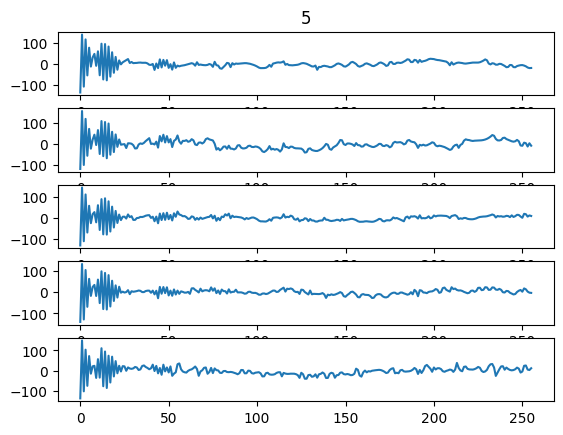

In [9]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

import matplotlib.pyplot as plt

%matplotlib inline
for eegs, labels in train_loader:
    print(eegs.shape)

    plt.figure()
    for i in range(n_channels):
        plt.subplot(n_channels, 1, i + 1)
        plt.plot(eegs[0][:, i])

        if i == 0:
            plt.title(labels[0].item())

    break

## Define Network

In [11]:
# from models import EEGCNN, ClassificationHead

# model = EEGCNN(n_channels, 16, 32)
# classifier = ClassificationHead(800)

# with torch.no_grad():
#     i, (eeg, label) = next(enumerate(train_loader))
#     embed = model(eeg)
#     print(embed.shape)
#     y = classifier(embed)
#     print(y.shape)

In [11]:
from models import EEGFeatNet, ClassificationHead

hidden_size = 220
model = EEGFeatNet(n_channels, hidden_size).to(device)
classifier = ClassificationHead(hidden_size * 2 * seq_len).to(device)
with torch.no_grad():
    i, (eeg, label) = next(enumerate(train_loader))
    eeg = eeg.to(device)
    print(eeg.shape)
    embed = model(eeg)
    print(embed.shape)
    y = classifier(embed)
    print(y.shape)

torch.Size([1024, 256, 5])
torch.Size([1024, 112640])
torch.Size([1024, 10])


/Users/sun/miniconda3/envs/cmput328/lib/python3.10/site-packages/torch/nn/modules/rnn.py:879: UserWarning: Native multi-layer LSTM support in MPS available only on MacOS 13 onwards. Falling back to LSTMCell iteration. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/RNN.cpp:1463.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [14]:
f"All Parameters: {sum(p.numel() for p in model.parameters())}"

'All Parameters: 3856170'

## Train Loop for Classifier

In [15]:
def train(model, classifier, optimizer, scheduler, train_loader, saving_loss=False):
    model = model.to(device).train()
    classifier = classifier.to(device).train()

    tq = tqdm(train_loader)
    total_loss = 0
    for batch_idx, (eegs, labels) in enumerate(tq):
        eegs = eegs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(eegs)
        y_pred = classifier(embeddings)

        loss = F.cross_entropy(y_pred, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if saving_loss:
            total_loss += loss.detach().item()
            tq.set_description(str(total_loss))

In [16]:
def eval(model, classifier, loader):
    model.to(device).eval()
    classifier.to(device).eval()

    tq = tqdm(loader)
    correct = 0
    total = 0
    for batch_idx, (eegs, labels) in enumerate(tq):
        eegs = eegs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = model(eegs)
            y_pred = classifier(embeddings)


        _, predicted = torch.max(y_pred.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total


In [17]:
# model = EEGFeatNet(n_channels=n_channels, n_features=n_features, projection_dim=projection_dim, num_layers=n_layers).to(device)
# classifier = ClassificationHead(hidden_size=projection_dim, num_classes=n_classes).to(device)

parameters = list(model.parameters()) + list(classifier.parameters())
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=weight_decay)

/Users/sun/miniconda3/envs/cmput328/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=n_epochs)

for epoch in range(n_epochs):
    if epoch % show_acc_freq == 0:
        saving_loss = True
    else:
        saving_loss = False
    train(model, classifier, optimizer, scheduler, train_loader, saving_loss)

  0%|          | 0/11 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [21]:
eval(model, classifier, test_loader)

100%|██████████| 11/11 [00:01<00:00, 10.03it/s]


0.10596786534047437

## Train Loop for Embedding

In [ ]:
from visualization import K_means

def train(epoch, model, optimizer, loss_fn, miner, train_dataloader):
    tq = tqdm(train_dataloader)
    for batch_idx, (eeg, label) in enumerate(tq, start=1):
        eeg    = eeg.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        x_proj = model(eeg)

        hard_pairs = miner(x_proj, labels)
        loss = loss_fn(x_proj, labels, hard_pairs)
        
        loss.backward()
        optimizer.step()

        running_loss = running_loss + [loss.detach().cpu().numpy()]
                
        tq.set_description('Train:[{}, {:0.3f}]'.format(epoch, loss.item()))

    if (epoch % vis_freq) == 0:
        for batch_idx, (eeg, labels) in enumerate(tqdm(train_dataloader)):
            eeg, labels = eeg.to(device), labels.to(device)
            with torch.no_grad():
                x_proj = model(eeg)
            
            eeg_featvec_proj = np.concatenate((eeg_featvec_proj, x_proj.cpu().detach().numpy()), axis=0) if eeg_featvec_proj.size else x_proj.cpu().detach().numpy()
            
            labels_array     = np.concatenate((labels_array, labels.cpu().detach().numpy()), axis=0) if labels_array.size else labels.cpu().detach().numpy()

        ### compute k-means score and Umap score on the text and image embeddings
        k_means = K_means(n_clusters=n_classes)
        clustering_acc_proj = k_means.transform(eeg_featvec_proj, labels_array)
        print("[Epoch: {}, Train KMeans score Proj: {}]".format(epoch, clustering_acc_proj))

    return running_loss

In [ ]:
from pytorch_metric_learning import miners, losses, distances

model = EEGFeatNet(n_channels=n_channels, n_features=n_features, projection_dim=projection_dim).to(device)
optimizer = torch.optim.AdamW(list(model.parameters()), lr=lr, weight_decay=weight_decay)

# miner = miners.MultiSimilarityMiner()
# loss_fn = losses.TripletMarginLoss()
margin = 0.2
distance = distances.LpDistance()
loss_fn = losses.TripletMarginLoss(margin, distance=distance)
miner = miners.TripletMarginMiner(margin, "semihard", distance=distance)

In [ ]:
if device == "cuda":
    torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs):
    running_train_loss = train(epoch, model, optimizer, loss_fn, miner, train_loader)

100%|██████████| 41/41 [00:00<00:00, 114.46it/s]


[Epoch: 0, Train KMeans score Proj: 0.112878497508624]


100%|██████████| 41/41 [00:00<00:00, 113.60it/s]


[Epoch: 10, Train KMeans score Proj: 0.11144116519739364]


100%|██████████| 41/41 [00:00<00:00, 117.05it/s]


[Epoch: 20, Train KMeans score Proj: 0.11057876581065543]


100%|██████████| 41/41 [00:00<00:00, 114.58it/s]


[Epoch: 30, Train KMeans score Proj: 0.11115369873514756]


100%|██████████| 41/41 [00:00<00:00, 119.88it/s]


[Epoch: 40, Train KMeans score Proj: 0.10415868148715983]


100%|██████████| 41/41 [00:00<00:00, 119.86it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 50, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 118.33it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 60, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 119.99it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 70, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 117.74it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 80, Train KMeans score Proj: 0.10367957071674971]


100%|██████████| 41/41 [00:00<00:00, 115.83it/s]
c:\Users\ruoto\miniconda3\envs\cmput328\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[Epoch: 90, Train KMeans score Proj: 0.10367957071674971]


Train:[99, 0.001]: 100%|██████████| 41/41 [00:00<00:00, 49.92it/s]
